# TomTom Traffic Incidents Animation

Use this notebook to process traffic incident data from a GeoJSON file. It visualizes the incidents over time on a basemap, and creates an animation to illustrate how delays evolve. 


## 1. Imports


In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx
import os
from tqdm.notebook import tqdm

## 2. Parameters

In [15]:
geojson_file = 'Christmas_in_Singapore.geojson'
anim_dir = "anim"
basemap_file = r"anim\basemap_images\basemap_CartoDB_VoyagerLabelsUnder.tif" 

min_time = datetime.fromisoformat('2024-12-18T20:30:00+07:00')
max_time = datetime.fromisoformat('2024-12-27T18:00:00+07:00')
step_size = timedelta(minutes=10)

- *geojson_file:* The source of traffic incident data
- *anim_dir:* Directory for storing animation-related files.
- *basemap_file:* Pre-downloaded basemap image to avoid multiple API calls.
- *min_time* & *max_time*: Define the period over which the animation will run.
- *step_size*: Determines the granularity of the animation frames.

Also check :
 - [`w,s,e,n` *if basemap not downloaded*](#4-download-basemaps)
 - [`ffmpeg_path` *to specify local ffmpeg install*](#8-create-video-using-ffmpeg) 


## 3. Load Data and Prepare Dirs


In [3]:
# Load the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file(geojson_file)

# Create animation directory
os.makedirs(anim_dir, exist_ok = True)

# Create a temporary directory in animation directory to store frames
temp_dir = os.path.join(anim_dir, 'temp')
os.makedirs(temp_dir, exist_ok = True)

## 4. Download Basemaps

When called, **download_basemaps** will try to download all available basemaps for the given location. 

**<span style="color:red">!!!</span>** Edit the `w, s, e, n` params in case location is not *Singapore*

In [4]:
def download_basemaps():
  provider_list = [
      ctx.providers.OpenStreetMap.Mapnik,
      ctx.providers.OpenStreetMap.DE,
      ctx.providers.OpenStreetMap.CH,
      ctx.providers.OpenStreetMap.France,
      ctx.providers.OpenStreetMap.HOT,
      ctx.providers.OpenStreetMap.BZH,
      ctx.providers.OpenStreetMap.BlackAndWhite,
      ctx.providers.MapTilesAPI.OSMEnglish,
      ctx.providers.MapTilesAPI.OSMFrancais,
      ctx.providers.MapTilesAPI.OSMEspagnol,
      ctx.providers.OpenSeaMap,
      ctx.providers.OPNVKarte,
      ctx.providers.OpenTopoMap,
      ctx.providers.OpenRailwayMap,
      ctx.providers.OpenFireMap,
      ctx.providers.SafeCast,
      ctx.providers.Stadia.AlidadeSmooth,
      ctx.providers.Stadia.AlidadeSmoothDark,
      ctx.providers.Stadia.AlidadeSatellite,
      ctx.providers.Stadia.OSMBright,
      ctx.providers.Stadia.Outdoors,
      ctx.providers.Stadia.StamenToner,
      ctx.providers.Stadia.StamenTonerBackground,
      ctx.providers.Stadia.StamenTonerLines,
      ctx.providers.Stadia.StamenTonerLabels,
      ctx.providers.Stadia.StamenTonerLite,
      ctx.providers.Stadia.StamenWatercolor,
      ctx.providers.Stadia.StamenTerrain,
      ctx.providers.Stadia.StamenTerrainBackground,
      ctx.providers.Stadia.StamenTerrainLabels,
      ctx.providers.Stadia.StamenTerrainLines,
      ctx.providers.Thunderforest.OpenCycleMap,
      ctx.providers.Thunderforest.Transport,
      ctx.providers.Thunderforest.TransportDark,
      ctx.providers.Thunderforest.SpinalMap,
      ctx.providers.Thunderforest.Landscape,
      ctx.providers.Thunderforest.Outdoors,
      ctx.providers.Thunderforest.Pioneer,
      ctx.providers.Thunderforest.MobileAtlas,
      ctx.providers.Thunderforest.Neighbourhood,
      ctx.providers.BaseMapDE.Color,
      ctx.providers.BaseMapDE.Grey,
      ctx.providers.CyclOSM,
      ctx.providers.Jawg.Streets,
      ctx.providers.Jawg.Terrain,
      ctx.providers.Jawg.Lagoon,
      ctx.providers.Jawg.Sunny,
      ctx.providers.Jawg.Dark,
      ctx.providers.Jawg.Light,
      ctx.providers.Jawg.Matrix,
      ctx.providers.MapBox,
      ctx.providers.MapTiler.Streets,
      ctx.providers.MapTiler.Basic,
      ctx.providers.MapTiler.Bright,
      ctx.providers.MapTiler.Pastel,
      ctx.providers.MapTiler.Positron,
      ctx.providers.MapTiler.Hybrid,
      ctx.providers.MapTiler.Toner,
      ctx.providers.MapTiler.Topo,
      ctx.providers.MapTiler.Voyager,
      ctx.providers.MapTiler.Ocean,
      ctx.providers.MapTiler.Backdrop,
      ctx.providers.MapTiler.Dataviz,
      ctx.providers.MapTiler.Basic4326,
      ctx.providers.MapTiler.Outdoor,
      ctx.providers.MapTiler.Topographique,
      ctx.providers.MapTiler.Winter,
      ctx.providers.MapTiler.Satellite,
      ctx.providers.MapTiler.Terrain,
      ctx.providers.TomTom.Basic,
      ctx.providers.TomTom.Hybrid,
      ctx.providers.TomTom.Labels,
      ctx.providers.Esri.WorldStreetMap,
      ctx.providers.Esri.WorldTopoMap,
      ctx.providers.Esri.WorldImagery,
      ctx.providers.Esri.WorldTerrain,
      ctx.providers.Esri.WorldShadedRelief,
      ctx.providers.Esri.WorldPhysical,
      ctx.providers.Esri.OceanBasemap,
      ctx.providers.Esri.NatGeoWorldMap,
      ctx.providers.Esri.WorldGrayCanvas,
      ctx.providers.Esri.ArcticImagery,
      ctx.providers.Esri.ArcticOceanBase,
      ctx.providers.Esri.ArcticOceanReference,
      ctx.providers.Esri.AntarcticImagery,
      ctx.providers.Esri.AntarcticBasemap,
      ctx.providers.OpenWeatherMap.Clouds,
      ctx.providers.OpenWeatherMap.CloudsClassic,
      ctx.providers.OpenWeatherMap.Precipitation,
      ctx.providers.OpenWeatherMap.PrecipitationClassic,
      ctx.providers.OpenWeatherMap.Rain,
      ctx.providers.OpenWeatherMap.RainClassic,
      ctx.providers.OpenWeatherMap.Pressure,
      ctx.providers.OpenWeatherMap.PressureContour,
      ctx.providers.OpenWeatherMap.Wind,
      ctx.providers.OpenWeatherMap.Temperature,
      ctx.providers.OpenWeatherMap.Snow,
      ctx.providers.HERE.normalDay,
      ctx.providers.HERE.normalDayCustom,
      ctx.providers.HERE.normalDayGrey,
      ctx.providers.HERE.normalDayMobile,
      ctx.providers.HERE.normalDayGreyMobile,
      ctx.providers.HERE.normalDayTransit,
      ctx.providers.HERE.normalDayTransitMobile,
      ctx.providers.HERE.normalDayTraffic,
      ctx.providers.HERE.normalNight,
      ctx.providers.HERE.normalNightMobile,
      ctx.providers.HERE.normalNightGrey,
      ctx.providers.HERE.normalNightGreyMobile,
      ctx.providers.HERE.normalNightTransit,
      ctx.providers.HERE.normalNightTransitMobile,
      ctx.providers.HERE.reducedDay,
      ctx.providers.HERE.reducedNight,
      ctx.providers.HERE.basicMap,
      ctx.providers.HERE.mapLabels,
      ctx.providers.HERE.trafficFlow,
      ctx.providers.HERE.carnavDayGrey,
      ctx.providers.HERE.hybridDay,
      ctx.providers.HERE.hybridDayMobile,
      ctx.providers.HERE.hybridDayTransit,
      ctx.providers.HERE.hybridDayGrey,
      ctx.providers.HERE.hybridDayTraffic,
      ctx.providers.HERE.pedestrianDay,
      ctx.providers.HERE.pedestrianNight,
      ctx.providers.HERE.satelliteDay,
      ctx.providers.HERE.terrainDay,
      ctx.providers.HERE.terrainDayMobile,
      ctx.providers.HEREv3.normalDay,
      ctx.providers.HEREv3.normalDayCustom,
      ctx.providers.HEREv3.normalDayGrey,
      ctx.providers.HEREv3.normalDayMobile,
      ctx.providers.HEREv3.normalDayGreyMobile,
      ctx.providers.HEREv3.normalDayTransit,
      ctx.providers.HEREv3.normalDayTransitMobile,
      ctx.providers.HEREv3.normalNight,
      ctx.providers.HEREv3.normalNightMobile,
      ctx.providers.HEREv3.normalNightGrey,
      ctx.providers.HEREv3.normalNightGreyMobile,
      ctx.providers.HEREv3.normalNightTransit,
      ctx.providers.HEREv3.normalNightTransitMobile,
      ctx.providers.HEREv3.reducedDay,
      ctx.providers.HEREv3.reducedNight,
      ctx.providers.HEREv3.basicMap,
      ctx.providers.HEREv3.mapLabels,
      ctx.providers.HEREv3.trafficFlow,
      ctx.providers.HEREv3.carnavDayGrey,
      ctx.providers.HEREv3.hybridDay,
      ctx.providers.HEREv3.hybridDayMobile,
      ctx.providers.HEREv3.hybridDayTransit,
      ctx.providers.HEREv3.hybridDayGrey,
      ctx.providers.HEREv3.pedestrianDay,
      ctx.providers.HEREv3.pedestrianNight,
      ctx.providers.HEREv3.satelliteDay,
      ctx.providers.HEREv3.terrainDay,
      ctx.providers.HEREv3.terrainDayMobile,
      ctx.providers.FreeMapSK,
      ctx.providers.MtbMap,
      ctx.providers.CartoDB.Positron,
      ctx.providers.CartoDB.PositronNoLabels,
      ctx.providers.CartoDB.PositronOnlyLabels,
      ctx.providers.CartoDB.DarkMatter,
      ctx.providers.CartoDB.DarkMatterNoLabels,
      ctx.providers.CartoDB.DarkMatterOnlyLabels,
      ctx.providers.CartoDB.Voyager,
      ctx.providers.CartoDB.VoyagerNoLabels,
      ctx.providers.CartoDB.VoyagerOnlyLabels,
      ctx.providers.CartoDB.VoyagerLabelsUnder,
      ctx.providers.HikeBike.HikeBike,
      ctx.providers.HikeBike.HillShading,
      ctx.providers.BasemapAT.basemap,
      ctx.providers.BasemapAT.grau,
      ctx.providers.BasemapAT.overlay,
      ctx.providers.BasemapAT.terrain,
      ctx.providers.BasemapAT.surface,
      ctx.providers.BasemapAT.highdpi,
      ctx.providers.BasemapAT.orthofoto,
      ctx.providers.nlmaps.standaard,
      ctx.providers.nlmaps.pastel,
      ctx.providers.nlmaps.grijs,
      ctx.providers.nlmaps.water,
      ctx.providers.nlmaps.luchtfoto,
      ctx.providers.NASAGIBS.ModisTerraTrueColorCR,
      ctx.providers.NASAGIBS.ModisTerraBands367CR,
      ctx.providers.NASAGIBS.ViirsEarthAtNight2012,
      ctx.providers.NASAGIBS.ModisTerraLSTDay,
      ctx.providers.NASAGIBS.ModisTerraSnowCover,
      ctx.providers.NASAGIBS.ModisTerraAOD,
      ctx.providers.NASAGIBS.ModisTerraChlorophyll,
      ctx.providers.NASAGIBS.ModisTerraBands721CR,
      ctx.providers.NASAGIBS.ModisAquaTrueColorCR,
      ctx.providers.NASAGIBS.ModisAquaBands721CR,
      ctx.providers.NASAGIBS.ViirsTrueColorCR,
      ctx.providers.NASAGIBS.BlueMarble,
      ctx.providers.NASAGIBS.BlueMarble3413,
      ctx.providers.NASAGIBS.BlueMarble3031,
      ctx.providers.NASAGIBS.BlueMarbleBathymetry3413,
      ctx.providers.NASAGIBS.BlueMarbleBathymetry3031,
      ctx.providers.NASAGIBS.MEaSUREsIceVelocity3413,
      ctx.providers.NASAGIBS.MEaSUREsIceVelocity3031,
      ctx.providers.NASAGIBS.ASTER_GDEM_Greyscale_Shaded_Relief,
      ctx.providers.NLS.osgb63k1885,
      ctx.providers.NLS.osgb1888,
      ctx.providers.NLS.osgb10k1888,
      ctx.providers.NLS.osgb1919,
      ctx.providers.NLS.osgb25k1937,
      ctx.providers.NLS.osgb63k1955,
      ctx.providers.NLS.oslondon1k1893,
      ctx.providers.JusticeMap.income,
      ctx.providers.JusticeMap.americanIndian,
      ctx.providers.JusticeMap.asian,
      ctx.providers.JusticeMap.black,
      ctx.providers.JusticeMap.hispanic,
      ctx.providers.JusticeMap.multi,
      ctx.providers.JusticeMap.nonWhite,
      ctx.providers.JusticeMap.white,
      ctx.providers.JusticeMap.plurality,
      ctx.providers.GeoportailFrance.plan,
      ctx.providers.GeoportailFrance.parcels,
      ctx.providers.GeoportailFrance.orthos,
      ctx.providers.GeoportailFrance.Acces_Biomethane,
      ctx.providers.GeoportailFrance.Adminexpress_cog_carto_Latest,
      ctx.providers.GeoportailFrance.Adminexpress_cog_Latest,
      ctx.providers.GeoportailFrance.Adminexpress_cog_2020,
      ctx.providers.GeoportailFrance.Areamanagement_Zfu,
      ctx.providers.GeoportailFrance.Areamanagement_Zus,
      ctx.providers.GeoportailFrance.Bdcarto_etat_major_Niveau3,
      ctx.providers.GeoportailFrance.Bdcarto_etat_major_Niveau4,
      ctx.providers.GeoportailFrance.Besoin_Chaleur_Industriel,
      ctx.providers.GeoportailFrance.Besoin_Chaleur_Residentiel,
      ctx.providers.GeoportailFrance.Besoin_Chaleur_Tertiaire,
      ctx.providers.GeoportailFrance.Besoin_Froid_Residentiel,
      ctx.providers.GeoportailFrance.Besoin_Froid_Tertiaire,
      ctx.providers.GeoportailFrance.Buildings_Buildings,
      ctx.providers.GeoportailFrance.Cadastral_Parcels_Sections,
      ctx.providers.GeoportailFrance.Cadastralparcels_Heatmap,
      ctx.providers.GeoportailFrance.Cadastralparcels_Histo_2008_2013_Parcels,
      ctx.providers.GeoportailFrance.Cadastralparcels_Parcels,
      ctx.providers.GeoportailFrance.Cadastralparcels_Qualrefbdp,
      ctx.providers.GeoportailFrance.Cadastres_Solaires_Locaux,
      ctx.providers.GeoportailFrance.Capacite_Accueil_Electrique,
      ctx.providers.GeoportailFrance.Cartes_Naturalearth,
      ctx.providers.GeoportailFrance.Cget_qp_bdd_wld_wm_wmts_20150914,
      ctx.providers.GeoportailFrance.Communes_Prioritydisctrict,
      ctx.providers.GeoportailFrance.Communes_Sismicite,
      ctx.providers.GeoportailFrance.Conso_Elec_Commune,
      ctx.providers.GeoportailFrance.Conso_Gaz_Commune,
      ctx.providers.GeoportailFrance.Cosia,
      ctx.providers.GeoportailFrance.Carhab_habitat,
      ctx.providers.GeoportailFrance.Debroussaillement,
      ctx.providers.GeoportailFrance.Delaisses_Autoroutiers,
      ctx.providers.GeoportailFrance.Delmar_wmts,
      ctx.providers.GeoportailFrance.Dreal_Zonage_pinel,
      ctx.providers.GeoportailFrance.Edugeo_Landuse_Agriculture2012,
      ctx.providers.GeoportailFrance.Edugeo_Naturalriskzones_1910floodedwatersheds,
      ctx.providers.GeoportailFrance.Elevation_Contour_Line,
      ctx.providers.GeoportailFrance.Elevation_Elevationgridcoverage_Shadow,
      ctx.providers.GeoportailFrance.Elevation_Elevationgridcoverage_Threshold,
      ctx.providers.GeoportailFrance.Elevation_Level0,
      ctx.providers.GeoportailFrance.Elevation_Slopes,
      ctx.providers.GeoportailFrance.Elevation_Slopes_Highres,
      ctx.providers.GeoportailFrance.Elevationgridcoverage_Highres_Quality,
      ctx.providers.GeoportailFrance.Enr_Aero_Civil,
      ctx.providers.GeoportailFrance.Enr_Aero_Militaire,
      ctx.providers.GeoportailFrance.Enr_Grands_Sites_France,
      ctx.providers.GeoportailFrance.Enr_Perimetre_Habitation,
      ctx.providers.GeoportailFrance.Enr_Perimetre_Pente,
      ctx.providers.GeoportailFrance.Enr_Perimetre_Route,
      ctx.providers.GeoportailFrance.Enr_Perimetre_Voie_Ferree,
      ctx.providers.GeoportailFrance.Enrezo_Besoins_Chaud,
      ctx.providers.GeoportailFrance.Enrezo_Besoins_Froid,
      ctx.providers.GeoportailFrance.Enrezo_Chaleur_Fatale_500_Industries,
      ctx.providers.GeoportailFrance.Enrezo_Chaleur_Fatale_Datacenter,
      ctx.providers.GeoportailFrance.Enrezo_Chaleur_Fatale_Step,
      ctx.providers.GeoportailFrance.Enrezo_Zone_Potentiel_Chaud,
      ctx.providers.GeoportailFrance.Enrezo_Zone_Potentiel_Fort_Chaud,
      ctx.providers.GeoportailFrance.Enrezo_Zone_Potentiel_Fort_Froid,
      ctx.providers.GeoportailFrance.Enrezo_Zone_Potentiel_Froid,
      ctx.providers.GeoportailFrance.Forets_Publiques,
      ctx.providers.GeoportailFrance.Gaz_Corridor_Distribution,
      ctx.providers.GeoportailFrance.Gaz_Corridor_Transport,
      ctx.providers.GeoportailFrance.Gaz_Reseau_Distribution,
      ctx.providers.GeoportailFrance.Gaz_Reseau_Transport,
      ctx.providers.GeoportailFrance.Geographicalgridsystem_Dfci,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_1900typemaps,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_1914_11_15_arras_verdun_belfort_fronts_600k,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Bonne,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Coastalmaps,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Douaumont_fort_positions_5k_18mai1916,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Ajaccio1976,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Berry_sud1952,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Bethune1956,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Belfort_montbelliard1973,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Biarritz1979,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Bourg_st_maurice1974,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Caen1969,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Cap_dagde1971,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Clermont_ferrand1966,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Creil_sud_picardie1979,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Dijon1962,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Douaumont1916,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Grenoble1965,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Grenoble1976,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Grenoble1991,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Guadeloupe1955,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Guyane1958,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_La_reunion1980,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_La_rochelle_rochefort1959,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Le_havre1975,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Le_havre1979,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Limoges1966,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Lyon1947,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Lyon1980,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Lyon1985,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Le_mort_homme_et_ses_environs_avril_1916,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Marne_la_vallee1966,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Marne_la_vallee1978,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Marne_la_vallee1987,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Marseille_martigues1947,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Marseille_martigues1980,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Marseille_martigues1986,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Metz_nancy1983,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Nantes1972,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Paris1964,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Paris1979,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Positions_20k_avr1916,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Reims1974,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Roissy1973,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Roissy1978,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Strasbourg1956,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Strasbourg1978,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Toulon_hyeres1976,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Toulouse1948,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Vannes_golfe_du_morbihan1960,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Vannes_golfe_du_morbihan1971,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Verdun_nord_fronts_francais_20k,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Verdun_nord_organisations_defensives_20k,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Edugeo_Versailles1979,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Etatmajor10,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Etatmajor40,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Maps_Bduni_J1,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Maps_Overview,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Maps_Scan50_1950,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Slopes_Mountain,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Slopes_Pac,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Terrier_v1,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Terrier_v2,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Verdun_environs_nord_fronts_offensves_50k,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Verdun_environs_sud_nord_com_group_80k,
      ctx.providers.GeoportailFrance.Geographicalgridsystems_Verdun_environs_fronts_50k_21_26fevr1916,
      ctx.providers.GeoportailFrance.Geographicalnames_Names,
      ctx.providers.GeoportailFrance.Hr_Orthoimagery_Orthophotos,
      ctx.providers.GeoportailFrance.Hydrography_Bcae_2020,
      ctx.providers.GeoportailFrance.Hydrography_Bcae_2021,
      ctx.providers.GeoportailFrance.Hydrography_Bcae_2022,
      ctx.providers.GeoportailFrance.Hydrography_Bcae_2023,
      ctx.providers.GeoportailFrance.Hydrography_Bcae_2024,
      ctx.providers.GeoportailFrance.Hydrography_Bcae_Latest,
      ctx.providers.GeoportailFrance.Hydrography_Hydrography,
      ctx.providers.GeoportailFrance.Inpe,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Enfants_0_17_Ans_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Logements_Surface_Moyenne_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Niveau_De_Vie_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Part_Familles_Monoparentales_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Part_Individus_25_39_Ans_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Part_Individus_40_54_Ans_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Part_Individus_55_64_Ans_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Part_Logements_Apres_1990_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Part_Logements_Avant_1945_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Part_Logements_Collectifs_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Part_Logements_Construits_1945_1970_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Part_Logements_Construits_1970_1990_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Part_Logements_Sociaux_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Part_Menages_1_Personne_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Part_Menages_5_Personnes_Ouplus_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Part_Menages_Maison_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Part_Menages_Pauvres_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Part_Menages_Proprietaires_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Part_Plus_65_Ans_Secret,
      ctx.providers.GeoportailFrance.Insee_Filosofi_Population,
      ctx.providers.GeoportailFrance.Landcover_Cha00,
      ctx.providers.GeoportailFrance.Landcover_Cha00_fr,
      ctx.providers.GeoportailFrance.Landcover_Cha06,
      ctx.providers.GeoportailFrance.Landcover_Cha06_dom,
      ctx.providers.GeoportailFrance.Landcover_Cha06_fr,
      ctx.providers.GeoportailFrance.Landcover_Cha12,
      ctx.providers.GeoportailFrance.Landcover_Cha12_dom,
      ctx.providers.GeoportailFrance.Landcover_Cha12_fr,
      ctx.providers.GeoportailFrance.Landcover_Cha18,
      ctx.providers.GeoportailFrance.Landcover_Cha18_dom,
      ctx.providers.GeoportailFrance.Landcover_Cha18_fr,
      ctx.providers.GeoportailFrance.Landcover_Clc00,
      ctx.providers.GeoportailFrance.Landcover_Clc00r,
      ctx.providers.GeoportailFrance.Landcover_Clc00r_fr,
      ctx.providers.GeoportailFrance.Landcover_Clc00_dom,
      ctx.providers.GeoportailFrance.Landcover_Clc00_fr,
      ctx.providers.GeoportailFrance.Landcover_Clc06,
      ctx.providers.GeoportailFrance.Landcover_Clc06r,
      ctx.providers.GeoportailFrance.Landcover_Clc06r_dom,
      ctx.providers.GeoportailFrance.Landcover_Clc06r_fr,
      ctx.providers.GeoportailFrance.Landcover_Clc06_dom,
      ctx.providers.GeoportailFrance.Landcover_Clc06_fr,
      ctx.providers.GeoportailFrance.Landcover_Clc12,
      ctx.providers.GeoportailFrance.Landcover_Clc12r,
      ctx.providers.GeoportailFrance.Landcover_Clc12r_dom,
      ctx.providers.GeoportailFrance.Landcover_Clc12r_fr,
      ctx.providers.GeoportailFrance.Landcover_Clc12_dom,
      ctx.providers.GeoportailFrance.Landcover_Clc12_fr,
      ctx.providers.GeoportailFrance.Landcover_Clc18,
      ctx.providers.GeoportailFrance.Landcover_Clc18_dom,
      ctx.providers.GeoportailFrance.Landcover_Clc18_fr,
      ctx.providers.GeoportailFrance.Landcover_Clc90,
      ctx.providers.GeoportailFrance.Landcover_Clc90_fr,
      ctx.providers.GeoportailFrance.Landcover_Edugeo_Evol_surface_forestiere_1980_2011,
      ctx.providers.GeoportailFrance.Landcover_Edugeo_Klaus,
      ctx.providers.GeoportailFrance.Landcover_Edugeo_Lgv_archeologie,
      ctx.providers.GeoportailFrance.Landcover_Edugeo_Lgv_faune,
      ctx.providers.GeoportailFrance.Landcover_Edugeo_Lgv_flore,
      ctx.providers.GeoportailFrance.Landcover_Edugeo_Lgv_technique,
      ctx.providers.GeoportailFrance.Landcover_Edugeo_Taux_boisement_2009_2013,
      ctx.providers.GeoportailFrance.Landcover_Forestareas,
      ctx.providers.GeoportailFrance.Landcover_Forestinventory_V1,
      ctx.providers.GeoportailFrance.Landcover_Forestinventory_V2,
      ctx.providers.GeoportailFrance.Landcover_Grid_Clc00,
      ctx.providers.GeoportailFrance.Landcover_Grid_Clc00r_fr,
      ctx.providers.GeoportailFrance.Landcover_Grid_Clc00_dom,
      ctx.providers.GeoportailFrance.Landcover_Grid_Clc00_fr,
      ctx.providers.GeoportailFrance.Landcover_Grid_Clc06,
      ctx.providers.GeoportailFrance.Landcover_Grid_Clc06r,
      ctx.providers.GeoportailFrance.Landcover_Grid_Clc06r_dom,
      ctx.providers.GeoportailFrance.Landcover_Grid_Clc06r_fr,
      ctx.providers.GeoportailFrance.Landcover_Grid_Clc06_dom,
      ctx.providers.GeoportailFrance.Landcover_Grid_Clc06_fr,
      ctx.providers.GeoportailFrance.Landcover_Grid_Clc12,
      ctx.providers.GeoportailFrance.Landcover_Grid_Clc12_dom,
      ctx.providers.GeoportailFrance.Landcover_Grid_Clc12_fr,
      ctx.providers.GeoportailFrance.Landcover_Grid_Clc90_fr,
      ctx.providers.GeoportailFrance.Landcover_Hr_Dlt_Clc12,
      ctx.providers.GeoportailFrance.Landcover_Hr_Dlt_Clc15,
      ctx.providers.GeoportailFrance.Landcover_Hr_Gra_Clc15,
      ctx.providers.GeoportailFrance.Landcover_Hr_Imd_Clc12,
      ctx.providers.GeoportailFrance.Landcover_Hr_Imd_Clc15,
      ctx.providers.GeoportailFrance.Landcover_Hr_Tcd_Clc12,
      ctx.providers.GeoportailFrance.Landcover_Hr_Tcd_Clc15,
      ctx.providers.GeoportailFrance.Landcover_Hr_Waw_Clc15,
      ctx.providers.GeoportailFrance.Landcover_Sylvoecoregions,
      ctx.providers.GeoportailFrance.Landcover_Sylvoecoregions_Alluvium,
      ctx.providers.GeoportailFrance.Landuse_Agriculture_Latest,
      ctx.providers.GeoportailFrance.Landuse_Agriculture2007,
      ctx.providers.GeoportailFrance.Landuse_Agriculture2008,
      ctx.providers.GeoportailFrance.Landuse_Agriculture2009,
      ctx.providers.GeoportailFrance.Landuse_Agriculture2010,
      ctx.providers.GeoportailFrance.Landuse_Agriculture2011,
      ctx.providers.GeoportailFrance.Landuse_Agriculture2012,
      ctx.providers.GeoportailFrance.Landuse_Agriculture2013,
      ctx.providers.GeoportailFrance.Landuse_Agriculture2014,
      ctx.providers.GeoportailFrance.Landuse_Agriculture2015,
      ctx.providers.GeoportailFrance.Landuse_Agriculture2016,
      ctx.providers.GeoportailFrance.Landuse_Agriculture2017,
      ctx.providers.GeoportailFrance.Landuse_Agriculture2018,
      ctx.providers.GeoportailFrance.Landuse_Agriculture2019,
      ctx.providers.GeoportailFrance.Landuse_Agriculture2020,
      ctx.providers.GeoportailFrance.Landuse_Agriculture2021,
      ctx.providers.GeoportailFrance.Landuse_Agriculture2022,
      ctx.providers.GeoportailFrance.Landuse_Agriculture2023,
      ctx.providers.GeoportailFrance.Limites_administratives_express_Latest,
      ctx.providers.GeoportailFrance.Litto3d_charente,
      ctx.providers.GeoportailFrance.Localisation_Concessions_Hydro,
      ctx.providers.GeoportailFrance.Localisation_Mats_Eolien,
      ctx.providers.GeoportailFrance.Naturalriskzones_1910floodedwatersheds,
      ctx.providers.GeoportailFrance.Ocsge_Construction_2010,
      ctx.providers.GeoportailFrance.Ocsge_Construction_2016_2017,
      ctx.providers.GeoportailFrance.Ocsge_Construction_2017_2020,
      ctx.providers.GeoportailFrance.Ocsge_Construction_2021_2023,
      ctx.providers.GeoportailFrance.Ocsge_Constructions,
      ctx.providers.GeoportailFrance.Ocsge_Constructions_2002,
      ctx.providers.GeoportailFrance.Ocsge_Constructions_2011,
      ctx.providers.GeoportailFrance.Ocsge_Constructions_2014,
      ctx.providers.GeoportailFrance.Ocsge_Constructions_2016,
      ctx.providers.GeoportailFrance.Ocsge_Constructions_2017,
      ctx.providers.GeoportailFrance.Ocsge_Constructions_2019,
      ctx.providers.GeoportailFrance.Ocsge_Couverture,
      ctx.providers.GeoportailFrance.Ocsge_Couverture_2002,
      ctx.providers.GeoportailFrance.Ocsge_Couverture_2010,
      ctx.providers.GeoportailFrance.Ocsge_Couverture_2011,
      ctx.providers.GeoportailFrance.Ocsge_Couverture_2014,
      ctx.providers.GeoportailFrance.Ocsge_Couverture_2016,
      ctx.providers.GeoportailFrance.Ocsge_Couverture_2016_2017,
      ctx.providers.GeoportailFrance.Ocsge_Couverture_2017,
      ctx.providers.GeoportailFrance.Ocsge_Couverture_2017_2020,
      ctx.providers.GeoportailFrance.Ocsge_Couverture_2019,
      ctx.providers.GeoportailFrance.Ocsge_Couverture_2021_2023,
      ctx.providers.GeoportailFrance.Ocsge_Usage,
      ctx.providers.GeoportailFrance.Ocsge_Usage_2002,
      ctx.providers.GeoportailFrance.Ocsge_Usage_2010,
      ctx.providers.GeoportailFrance.Ocsge_Usage_2011,
      ctx.providers.GeoportailFrance.Ocsge_Usage_2014,
      ctx.providers.GeoportailFrance.Ocsge_Usage_2016,
      ctx.providers.GeoportailFrance.Ocsge_Usage_2016_2017,
      ctx.providers.GeoportailFrance.Ocsge_Usage_2017,
      ctx.providers.GeoportailFrance.Ocsge_Usage_2017_2020,
      ctx.providers.GeoportailFrance.Ocsge_Usage_2019,
      ctx.providers.GeoportailFrance.Ocsge_Usage_2021_2023,
      ctx.providers.GeoportailFrance.Ocsge_Visu_2016,
      ctx.providers.GeoportailFrance.Ocsge_Visu_2019,
      ctx.providers.GeoportailFrance.Ofb_Zones_Exclues,
      ctx.providers.GeoportailFrance.Ofb_Zones_Exclues_Sauf_Toiture,
      ctx.providers.GeoportailFrance.Ofb_Zones_Necessitant_Avis_Gestionnaire,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Ajaccio1975,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Ajaccio1990,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Arcachon2010,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Arras_lens_bethune2008,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Belfort_montbelliard1951,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Berry_sud1950,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Berry_sud1970,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Bethune1963,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Bethune1964,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Bethune1988,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Biarritz1977,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Biarrtitz1979,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Bordeaux2003,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Bourg_st_maurice1956,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Caen1991,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Cap_d_agde1968,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Cap_d_agde2008,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Cap_dage1981,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Clermont_ferrand1965,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Clermont_ferrand1985,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Creil_sud_picardie1975,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Dijon1971,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Grenoble1966,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Grenoble1989,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Guadeloupe1984,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Guyane1955,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_La_reunion1961,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_La_reunion1980,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_La_reunion1989,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_La_reunion2010,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_La_rochelle_rochefort1973,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Le_havre1955,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Le_havre1964,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Le_havre2008,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Limoges1974,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Lyon1965,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Lyon1984,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Lyon1988,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Lyon2008,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Marne_la_vallee1965,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Marne_la_vallee1977,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Marne_la_vallee1987,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Marseille_martigues1969,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Marseille_martigues1980,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Marseille_martigues1987,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Marseille_martigues1988,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Marseille_martigues2010,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Martinique1988,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Metz_nancy1982,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Nantes1971,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Paris1949,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Paris1965,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Paris2010spot,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Reims1963,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Reims1973,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Reims1988,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Reims2010,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Roissy1965,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Roissy1987,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Strasbourg1975,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Strasbourg1985,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Strasbourg2010,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Toulon_hyeres1972,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Toulouse1954,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Valee_du_drac2010,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Vannes_golfe_du_morbihan1970,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Versailles1965,
      ctx.providers.GeoportailFrance.Orthoimagery_Edugeo_Versailles1989,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Pleiades_2012,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Pleiades_2013,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Pleiades_2014,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Pleiades_2015,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Pleiades_2016,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Pleiades_2017,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Pleiades_2018,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Pleiades_2019,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Pleiades_2020,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Pleiades_2021,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Pleiades_2022,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Rapideye_2010,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Rapideye_2011,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Spot_2013,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Spot_2014,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Spot_2015,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Spot_2016,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Spot_2017,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Spot_2018,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Spot_2019,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Spot_2020,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Spot_2021,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Spot_2022,
      ctx.providers.GeoportailFrance.Orthoimagery_Ortho_sat_Spot_2023,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophos_Restrictedareas,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_1950_1965,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_1965_1980,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_1980_1995,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Bdortho,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Coast2000,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Geneve,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Ilesdunord,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Irc,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Irc_express_2018,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Irc_express_2019,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Irc_express_2020,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Irc_express_2021,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Irc_express_2023,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Irc_express_2024,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Irc_2012,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Irc_2013,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Irc_2014,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Irc_2015,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Irc_2016,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Irc_2017,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Irc_2018,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Irc_2019,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Irc_2020,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Low_res_Crs84,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Ncl,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Ortho_asp_pac2020,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Ortho_asp_pac2021,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Ortho_asp_pac2022,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Ortho_asp_pac2024,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Ortho_express_2017,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Ortho_express_2018,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Ortho_express_2019,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Ortho_express_2020,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Ortho_express_2021,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Ortho_express_2023,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Ortho_express_2024,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Pre_Irma,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Rapideye,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Socle_asp_2018,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Spot5,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos_Urgence_Alex,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2000,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2000_2005,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2001,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2002,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2003,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2004,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2005,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2006,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2006_2010,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2007,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2008,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2009,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2010,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2011,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2011_2015,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2012,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2013,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2014,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2015,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2016,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2017,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2018,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2019,
      ctx.providers.GeoportailFrance.Orthoimagery_Orthophotos2020,
      ctx.providers.GeoportailFrance.Parking_Sup_500,
      ctx.providers.GeoportailFrance.Part_Enr_Commune,
      ctx.providers.GeoportailFrance.Pcrs_Lamb93,
      ctx.providers.GeoportailFrance.Points_Injection_Biomethane,
      ctx.providers.GeoportailFrance.Potentiel_Eolien_Reglementaire,
      ctx.providers.GeoportailFrance.Potentiel_Geothermie,
      ctx.providers.GeoportailFrance.Potentiel_Hydro,
      ctx.providers.GeoportailFrance.Potentiel_Reseau_Chaleur_Paca,
      ctx.providers.GeoportailFrance.Potentiel_Reseau_Chaud_Froid_Paca,
      ctx.providers.GeoportailFrance.Potentiel_Reseau_Froid_Paca,
      ctx.providers.GeoportailFrance.Potentiel_Solaire_Batiment,
      ctx.providers.GeoportailFrance.Potentiel_Solaire_Friche,
      ctx.providers.GeoportailFrance.Potentiel_Solaire_Parking500,
      ctx.providers.GeoportailFrance.Potentiel_Solaire_Rrn,
      ctx.providers.GeoportailFrance.Potentiel_Solaire_Sol,
      ctx.providers.GeoportailFrance.Prairies_Sensibles_Bcae,
      ctx.providers.GeoportailFrance.Prod_Installation_Eolien,
      ctx.providers.GeoportailFrance.Prod_Installation_Hydro,
      ctx.providers.GeoportailFrance.Prod_Installation_Pv,
      ctx.providers.GeoportailFrance.Productible_Biomethane_Commune,
      ctx.providers.GeoportailFrance.Productible_Eolien_Commune,
      ctx.providers.GeoportailFrance.Productible_Methanisation_Commune,
      ctx.providers.GeoportailFrance.Productible_Photovoltaique_Commune,
      ctx.providers.GeoportailFrance.Protectedareas_Apb,
      ctx.providers.GeoportailFrance.Protectedareas_Apg,
      ctx.providers.GeoportailFrance.Protectedareas_Aphn,
      ctx.providers.GeoportailFrance.Protectedareas_Aplg,
      ctx.providers.GeoportailFrance.Protectedareas_Bios,
      ctx.providers.GeoportailFrance.Protectedareas_Gp,
      ctx.providers.GeoportailFrance.Protectedareas_Inpg,
      ctx.providers.GeoportailFrance.Protectedareas_Mnhn_Cdl_Parcels,
      ctx.providers.GeoportailFrance.Protectedareas_Mnhn_Cdl_Perimeter,
      ctx.providers.GeoportailFrance.Protectedareas_Mnhn_Conservatoires,
      ctx.providers.GeoportailFrance.Protectedareas_Mnhn_Rn_Perimeter,
      ctx.providers.GeoportailFrance.Protectedareas_Pn,
      ctx.providers.GeoportailFrance.Protectedareas_Pnm,
      ctx.providers.GeoportailFrance.Protectedareas_Pnr,
      ctx.providers.GeoportailFrance.Protectedareas_Prsf,
      ctx.providers.GeoportailFrance.Protectedareas_Ramsar,
      ctx.providers.GeoportailFrance.Protectedareas_Rb,
      ctx.providers.GeoportailFrance.Protectedareas_Ripn,
      ctx.providers.GeoportailFrance.Protectedareas_Rn,
      ctx.providers.GeoportailFrance.Protectedareas_Rnc,
      ctx.providers.GeoportailFrance.Protectedareas_Rncf,
      ctx.providers.GeoportailFrance.Protectedareas_Sic,
      ctx.providers.GeoportailFrance.Protectedareas_Unesco,
      ctx.providers.GeoportailFrance.Protectedareas_Znieff1,
      ctx.providers.GeoportailFrance.Protectedareas_Znieff1_Sea,
      ctx.providers.GeoportailFrance.Protectedareas_Znieff2,
      ctx.providers.GeoportailFrance.Protectedareas_Znieff2_Sea,
      ctx.providers.GeoportailFrance.Protectedareas_Zpr,
      ctx.providers.GeoportailFrance.Protectedareas_Zps,
      ctx.providers.GeoportailFrance.Protectedsites_Mnhn_Reserves_regionales,
      ctx.providers.GeoportailFrance.Puissance_Installee_Biomethane,
      ctx.providers.GeoportailFrance.Puissance_Installee_Methanisation,
      ctx.providers.GeoportailFrance.Securoute_Te_1te,
      ctx.providers.GeoportailFrance.Securoute_Te_2te48,
      ctx.providers.GeoportailFrance.Securoute_Te_All,
      ctx.providers.GeoportailFrance.Securoute_Te_Oa,
      ctx.providers.GeoportailFrance.Securoute_Te_Pn,
      ctx.providers.GeoportailFrance.Securoute_Te_Pnd,
      ctx.providers.GeoportailFrance.Securoute_Te_Te120,
      ctx.providers.GeoportailFrance.Securoute_Te_Te72,
      ctx.providers.GeoportailFrance.Securoute_Te_Te94,
      ctx.providers.GeoportailFrance.Site_Production_Chaleur_Biogaz,
      ctx.providers.GeoportailFrance.Site_Production_Chaleur_Cogeneration,
      ctx.providers.GeoportailFrance.Site_Production_Chaleur_Dechets,
      ctx.providers.GeoportailFrance.Site_Production_Chaleur_Methanisaton,
      ctx.providers.GeoportailFrance.Site_Production_Chaleur_Rc,
      ctx.providers.GeoportailFrance.Site_Production_Chaleur_Rc_Bretagne,
      ctx.providers.GeoportailFrance.Site_Production_Chaleur_Rc_Paca,
      ctx.providers.GeoportailFrance.Site_Production_Chaleur_Rcf_Lineaire,
      ctx.providers.GeoportailFrance.Site_Production_Chaleur_Rcf_Point,
      ctx.providers.GeoportailFrance.Test_pbe_le_havre,
      ctx.providers.GeoportailFrance.Thr_Orthoimagery_Orthophotos,
      ctx.providers.GeoportailFrance.Traces_Rando_Hivernale,
      ctx.providers.GeoportailFrance.Transportnetwork_Commontransportelements_Markerpost,
      ctx.providers.GeoportailFrance.Transportnetwork_Commontransportelements_Markerpost_visu,
      ctx.providers.GeoportailFrance.Transportnetworks_Railways,
      ctx.providers.GeoportailFrance.Transportnetworks_Roads,
      ctx.providers.GeoportailFrance.Transportnetworks_Roads_Direction,
      ctx.providers.GeoportailFrance.Transportnetworks_Runways,
      ctx.providers.GeoportailFrance.Transports_Drones_Restrictions,
      ctx.providers.GeoportailFrance.Utilityandgovernmentalservices_All,
      ctx.providers.GeoportailFrance.Hedge_Hedge,
      ctx.providers.GeoportailFrance.Tuto_scan1000_srd,
      ctx.providers.OneMapSG.Default,
      ctx.providers.OneMapSG.Night,
      ctx.providers.OneMapSG.Original,
      ctx.providers.OneMapSG.Grey,
      ctx.providers.OneMapSG.LandLot,
      ctx.providers.USGS.USTopo,
      ctx.providers.USGS.USImagery,
      ctx.providers.USGS.USImageryTopo,
      ctx.providers.WaymarkedTrails.hiking,
      ctx.providers.WaymarkedTrails.cycling,
      ctx.providers.WaymarkedTrails.mtb,
      ctx.providers.WaymarkedTrails.slopes,
      ctx.providers.WaymarkedTrails.riding,
      ctx.providers.WaymarkedTrails.skating,
      ctx.providers.OpenAIP,
      ctx.providers.OpenSnowMap.pistes,
      ctx.providers.AzureMaps.MicrosoftImagery,
      ctx.providers.AzureMaps.MicrosoftBaseDarkGrey,
      ctx.providers.AzureMaps.MicrosoftBaseRoad,
      ctx.providers.AzureMaps.MicrosoftBaseHybridRoad,
      ctx.providers.AzureMaps.MicrosoftTerraMain,
      ctx.providers.AzureMaps.MicrosoftWeatherInfraredMain,
      ctx.providers.AzureMaps.MicrosoftWeatherRadarMain,
      ctx.providers.SwissFederalGeoportal.NationalMapColor,
      ctx.providers.SwissFederalGeoportal.NationalMapGrey,
      ctx.providers.SwissFederalGeoportal.SWISSIMAGE,
      ctx.providers.SwissFederalGeoportal.JourneyThroughTime,
      ctx.providers.TopPlusOpen.Color,
      ctx.providers.TopPlusOpen.Grey,
      ctx.providers.Gaode.Normal,
      ctx.providers.Gaode.Satellite,
      ctx.providers.Strava.All,
      ctx.providers.Strava.Ride,
      ctx.providers.Strava.Run,
      ctx.providers.Strava.Water,
      ctx.providers.Strava.Winter,
      ctx.providers.OrdnanceSurvey.Road,
      ctx.providers.OrdnanceSurvey.Road_27700,
      ctx.providers.OrdnanceSurvey.Outdoor,
      ctx.providers.OrdnanceSurvey.Outdoor_27700,
      ctx.providers.OrdnanceSurvey.Light,
      ctx.providers.OrdnanceSurvey.Light_27700,
      ctx.providers.OrdnanceSurvey.Leisure_27700
  ]

  success = []
  fail = []

  os.makedirs(os.path.join(anim_dir,"basemap_images"), exist_ok=True)

  def download_basemap(provider):
    try:
      name = '_'.join(provider['name'].split('.'))
      w, s, e, n = [103.56904815, 1.14331425, 104.06175685, 1.57723675]
      _ = ctx.bounds2raster(w, s, e, n,
                      ll=True,
                      path=os.path.join("basemap_images", f"basemap_{name}.tif"),
                      source=provider
                      )
      success.append(f"ctx.providers.{provider['name']},")
    except Exception as e :
      fail.append(f"ctx.providers.{provider['name']},")
      pass
  for provider in tqdm(provider_list) :
    download_basemap(provider)

  print(f"{len(success)} Successful downloads : ")
  print(success, '----------------------------------')
  print(f"{len(fail)} Failed downloads : ")
  print(fail, '\n \n')

In [5]:
if not os.path.exists(basemap_file):
	print(f"Basemap file {basemap_file} does not exist. Trying to download the basemap first.")
	download_basemaps()
	if not os.path.exists(basemap_file): 
		raise Exception(f"Basemap file {basemap_file} does not exist, download failed. Please download the basemap first.")

## 5. Plot Traffic Incidents on Basemap

- **filter_events_within_interval:** Ensures only relevant traffic incidents within the specified time frame are visualized.
- **plot_events_within_interval:**  Combines the basemap with the filtered traffic incidents, using a fixed colormap (`inferno`) to represent delays.

In [6]:
def filter_events_within_interval(gdf, min_time, max_time):
    # Convert 'startTime' and 'endTime' columns to datetime objects
    gdf['startTime'] = gdf['startTime'].apply(lambda x: datetime.fromisoformat(str(x)))
    gdf['endTime'] = gdf['endTime'].apply(lambda x: datetime.fromisoformat(str(x)) if x else None)

    # Filter incidents that are active within the time interval
    filtered_gdf = gdf[
        ((gdf['startTime'] <= max_time) & (gdf['endTime'] >= min_time)) |
        ((gdf['startTime'] <= max_time) & (gdf['endTime'].isnull()))
    ]
    return filtered_gdf

def plot_events_within_interval(gdf, min_time, max_time, tmz, delay_min, delay_max, basemap, crs):
    # Filter incidents within the time interval
    filtered_gdf = filter_events_within_interval(gdf, min_time, max_time)

    # Create the fig (necessary for axes lcoation)
    fig, ax = plt.subplots(1, 1)
    divider = make_axes_locatable(ax)

    # Use divider to force legend to be same size as map
    cax = divider.append_axes("bottom", size="5%", pad=0.1)

    # Plot the filtered incidents
    filtered_gdf.plot(ax=ax,
                      cax=cax,
                      column='delay',
                      legend=True, 
                      legend_kwds={"label": f"Delay caused by incidents between {min_time.astimezone(tmz).strftime('%d %b %y %H:%M')} and {max_time.astimezone(tmz).strftime('%d %b %y %H:%M')}", 
                                   "orientation": "horizontal"}, 
                      cmap='inferno',
                      vmin=delay_min, 
                      vmax=delay_max)
    
    # Hide axes 
    ax.axis("off")

    # Set plot limits (for consistency in-between frames)
    x_offset = (gdf.total_bounds[2] - gdf.total_bounds[0]) * 0.05
    y_offset = (gdf.total_bounds[3] - gdf.total_bounds[1]) * 0.05
    ax.set_xlim(gdf.total_bounds[0] - x_offset, gdf.total_bounds[2] + x_offset)
    ax.set_ylim(gdf.total_bounds[1] - y_offset, gdf.total_bounds[3] + y_offset)

    # Add basemap to the figure
    ctx.add_basemap(ax, crs=crs, source=basemap)

## 6. Create Individual Frame

Load the constants to all frames.

In [7]:
# Get the min and max delays to fix legend range
delay_min = gdf['delay'].min()
delay_max = gdf['delay'].max()

# Check coordinate reference system for displaying of points on basemap
crs = gdf.crs.to_string()

# Load the timezone information
tmz = min_time.astimezone().tzinfo
	

In [8]:
def animate_frame(i):
    current_time = min_time + i * step_size
    end_time = current_time + timedelta(hours=1)

    # Plot incidents for the current time interval
    plot_events_within_interval(gdf, current_time, end_time, tmz, delay_min, delay_max, basemap_file, crs)

    # Save the current frame as a PNG image
    plt.savefig(os.path.join(temp_dir, f"plot{i}.png"))
    plt.close()

- **animate_frame:** Generates individual frames by plotting incidents for each time interval and saving them as images.

## 7. Generate All Frames

  0%|          | 0/2562 [00:00<?, ?it/s]

ValueError: aspect must be finite and positive 

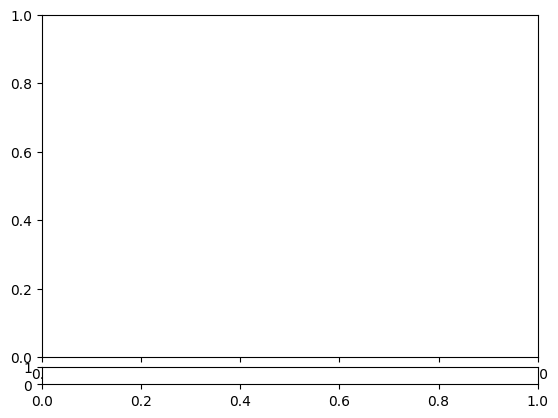

In [9]:
# Calculate total frames
frames = int((max_time - min_time) / step_size)

existing_frames = sorted([int(f.split('plot')[1].split('.png')[0]) for f in os.listdir(temp_dir) if f.startswith('plot') and f.endswith('.png')])

if existing_frames: last_frame = existing_frames[-1]
else : last_frame = 0
frame_range = range(last_frame, frames)

# Generate all frames and display progress bar
for i in tqdm(frame_range, dynamic_ncols=True): 
    animate_frame(i)

## 8. Create Video Using FFmpeg

Uses FFmpeg to combine all frames into animated mp4. Will iterate in name until free.

**<span style="color:red">!!!</span>** Edit `ffmpeg_path` to fit local install : if **`PATH`** not set, point directly to *.exe*, otherwise `ffmpeg` is sufficient

In [10]:
# Path to ffmpeg executable
ffmpeg_path = r"C:\ffmpeg\bin\ffmpeg.exe"

# Ppattern for ffmpeg to identify frame images, based on animate_frame pattern
input_pattern = os.path.join(temp_dir, r"plot%d.png")

# Output video file path
output_file = os.path.join(anim_dir, r"animation.mp4")

counter = 1
base_output_file = output_file
while os.path.exists(output_file):
    output_file = base_output_file.replace(".mp4", f"_{counter}.mp4")
    counter += 1


# Execute the ffmpeg command to create the video
ffmpeg_command = f'"{ffmpeg_path}" -hide_banner -loglevel error -framerate 12 -i "{input_pattern}" -c:v libx264 -pix_fmt yuv420p "{output_file}"'
print('> ' + ffmpeg_command)
!{ffmpeg_command}

> "C:\ffmpeg\bin\ffmpeg.exe" -hide_banner -loglevel error -framerate 12 -i "anim\temp\plot%d.png" -c:v libx264 -pix_fmt yuv420p "anim\animation.mp4"


## 9. Clean Up Temp Files

In [11]:
import shutil
shutil.rmtree(temp_dir)